1. 환경 데이터와 생산량 데이터 불러오기 (1-1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 환경 데이터 및 생산량 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')


2. 날짜 데이터 변환 및 주차 계산

In [2]:
# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

3. 환경 변수 적산 계산

In [3]:
# 3. 적산 계산을 위한 데이터 그룹화 (주차별로 누적 합계 계산)
env_weekly_cumulative = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'sum',     # 온도 적산
    'inHd': 'sum',     # 습도 적산
    'inCo2': 'sum'     # CO2 적산
}).reset_index()


4. 환경 변수와 생산량 데이터 병합 ->
환경 변수와 생산량 데이터를 연도와 주차를 기준으로 병합하여, 주차별 환경 조건과 해당 주차의 생산량 데이터를 결합

In [4]:
# 4. 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_cumulative, 
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량'])


5. 상관관계 분석

In [5]:
# 5. 상관관계 분석
correlation_data = merged_data[['inTp', 'inHd', 'inCo2', '생산량']]
correlation_matrix = correlation_data.corr()

# 상관관계 높은 순으로 나열
correlation_with_yield = correlation_matrix['생산량'].drop('생산량').sort_values(ascending=False)

# 결과 출력
print("\n상관관계가 높은 순서대로 나열된 변수들:")
print(correlation_with_yield)



상관관계가 높은 순서대로 나열된 변수들:
inCo2    0.293821
inHd     0.223081
inTp    -0.211695
Name: 생산량, dtype: float64


6. 상관관계 히트맵 그리기

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\

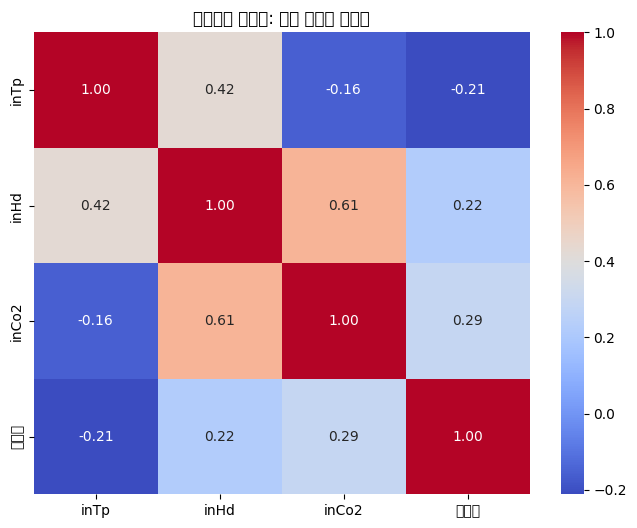

In [6]:
# 상관관계 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('상관관계 히트맵: 환경 변수와 생산량')
plt.show()


1. 필요한 라이브러리 임포트

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import matplotlib.pyplot as plt

2. 데이터 불러오기 및 전처리

In [8]:
# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

#  날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week


3. 환경 데이터 그룹화 및 생산량 데이터 병합

In [9]:
# . 적산 계산을 위한 데이터 그룹화 (주차별로 누적 합계 계산)
env_weekly_cumulative = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'sum',     # 온도 적산
    'inHd': 'sum',     # 습도 적산
    'inCo2': 'sum'     # CO2 적산
}).reset_index()

# . 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_cumulative, 
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner').dropna(subset=['생산량'])


4. 데이터 스케일링 및 시계열 데이터 생성

In [10]:
# . 특성과 타겟 데이터 분리
X = merged_data[['inTp', 'inHd', 'inCo2']].values  # 입력 변수 (온도, 습도, CO2 적산값)
y = merged_data['생산량'].values  # 타겟 변수 (생산량)

# . 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# . 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

5. 학습 및 테스트 데이터 분할

In [11]:
# . 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

6. LSTM 모델 구축 및 학습

In [12]:
# 9. LSTM 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.GRU(50, activation='relu'),  # GRU 층 추가
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.Dense(forecast_weeks)  # 예측할 주차 수 만큼의 출력 뉴런
])

# RMSprop 최적화 알고리즘으로 모델 컴파일
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64, callbacks=[early_stopping])


Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5774 - mae: 0.5766 - val_loss: 0.5119 - val_mae: 0.5750
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5350 - mae: 0.5384 - val_loss: 0.4790 - val_mae: 0.5461
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.5168 - mae: 0.5302 - val_loss: 0.4468 - val_mae: 0.5160
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4902 - mae: 0.5082 - val_loss: 0.4148 - val_mae: 0.4842
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4560 - mae: 0.4771 - val_loss: 0.3811 - val_mae: 0.4481
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4273 - mae: 0.4549 - val_loss: 0.3456 - val_mae: 0.4065
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4109 - mae: 0.4292 - val_loss: 0.3113 - val_mae: 0.3614
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3784 - mae: 0.4086 - val_loss: 0.2797 - val_mae: 0.3140
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3766 - mae: 0.4028 - val_l

7. 예측 및 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Deja

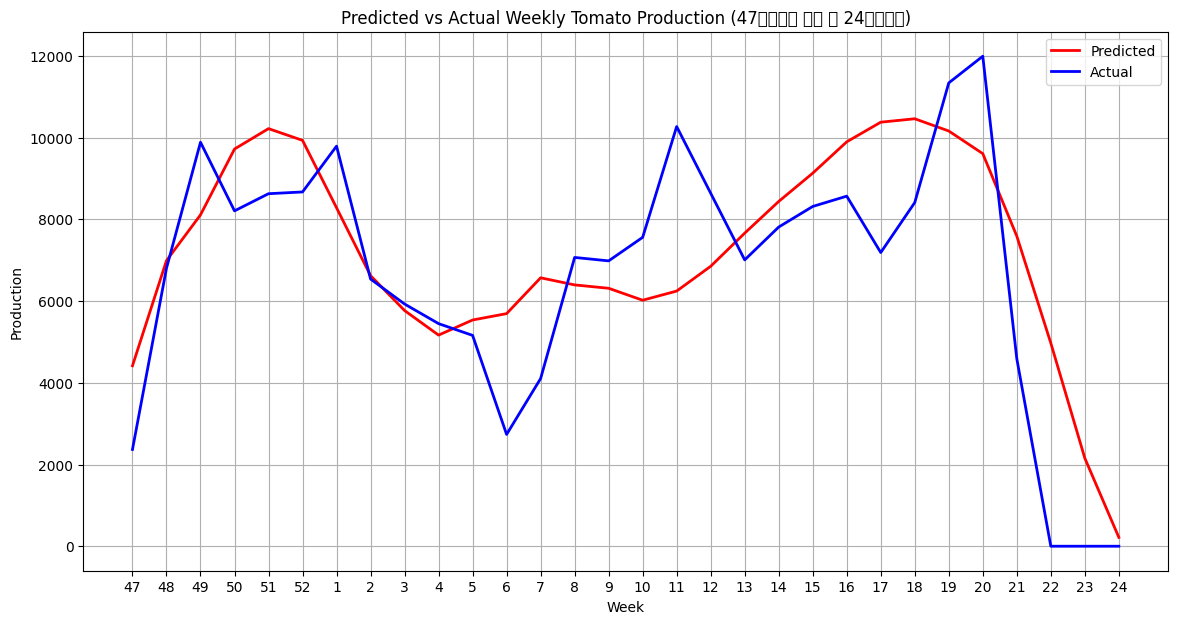

In [15]:
## 전체 데이터로 시퀀스 생성
X_seq = []
for i in range(len(X_scaled) - timesteps + 1):
    X_seq.append(X_scaled[i:i+timesteps])
X_seq = np.array(X_seq)

# 전체 데이터로 예측 수행
preds = model.predict(X_seq)
preds_inv = scaler_y.inverse_transform(preds)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_ext = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
preds_filtered = preds_inv[:len(weeks_ext)]  # 주차 범위에 맞춰 예측값 슬라이싱

# 실제 생산량 데이터 가져오기
actual_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
actual_data = actual_data.sort_values(by=['연도', '주차'])
actual_prod = actual_data['생산량'].values[:len(weeks_ext)]

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_ext)), preds_filtered.flatten(), label='Predicted', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_ext)), actual_prod, label='Actual', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_ext)), labels=weeks_ext)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
print("주차별 실제 생산량 및 예측된 생산량:")
for i in range(len(weeks_extended_full)):
    print(f"{weeks_extended_full[i]}주차 실제 생산량 : {actual_production[i]}, 예측 생산량 : {filtered_predictions.flatten()[i]}")

주차별 실제 생산량 및 예측된 생산량:
47주차 실제 생산량 : 2368, 예측 생산량 : 4416.50732421875
48주차 실제 생산량 : 6804, 예측 생산량 : 6990.931640625
49주차 실제 생산량 : 9888, 예측 생산량 : 8110.33056640625
50주차 실제 생산량 : 8208, 예측 생산량 : 9721.3828125
51주차 실제 생산량 : 8628, 예측 생산량 : 10220.732421875
52주차 실제 생산량 : 8671, 예측 생산량 : 9933.2998046875
1주차 실제 생산량 : 9792, 예측 생산량 : 8283.3388671875
2주차 실제 생산량 : 6540, 예측 생산량 : 6622.34521484375
3주차 실제 생산량 : 5928, 예측 생산량 : 5768.74365234375
4주차 실제 생산량 : 5448, 예측 생산량 : 5167.32861328125
5주차 실제 생산량 : 5160, 예측 생산량 : 5536.73291015625
6주차 실제 생산량 : 2736, 예측 생산량 : 5693.11669921875
7주차 실제 생산량 : 4104, 예측 생산량 : 6569.82275390625
8주차 실제 생산량 : 7068, 예측 생산량 : 6395.72607421875
9주차 실제 생산량 : 6984, 예측 생산량 : 6313.2919921875
10주차 실제 생산량 : 7560, 예측 생산량 : 6020.89306640625
11주차 실제 생산량 : 10272, 예측 생산량 : 6245.08154296875
12주차 실제 생산량 : 8640, 예측 생산량 : 6851.400390625
13주차 실제 생산량 : 7008, 예측 생산량 : 7662.75
14주차 실제 생산량 : 7812, 예측 생산량 : 8438.697265625
15주차 실제 생산량 : 8316, 예측 생산량 : 9130.4501953125
16주차 실제 생산량 : 8568, 예측 생산량 : 9897.6611328125